In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

C:\Users\Varad\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load the data
data_taken = pd.read_csv("Datasets/Final_Data_LPSv3.csv")

3    500
2    500
1    500
0    500
Name: label, dtype: int64

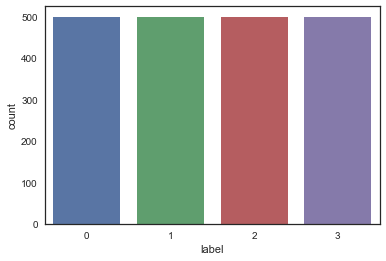

In [3]:
Y_train = data_taken["label"]

# Drop 'label' column
X_train = data_taken.drop(labels = ["label"], axis = 1) 

# free some space
del data_taken 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [4]:
# Check the data
X_train.isnull().any().describe()

count     10000
unique        1
top       False
freq      10000
dtype: object

In [5]:
# Normalize the data
X_train = X_train / 255.0

In [6]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,100,100,1)

In [7]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 4)

In [8]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 2)

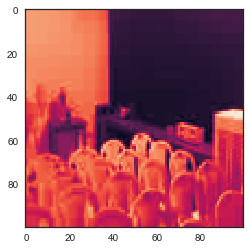

In [9]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

In [10]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                 activation ='relu', input_shape = (100,100,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               20480256  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [11]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [12]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [13]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
epochs = 10 
batch_size = 30

In [15]:
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [16]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(X_train)

In [17]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
46/46 [==============================] - 23s 504ms/step - loss: 2.3902 - acc: 0.3457 - val_loss: 1.5368 - val_acc: 0.4533
Epoch 2/10
46/46 [==============================] - 16s 357ms/step - loss: 1.4671 - acc: 0.4859 - val_loss: 1.2270 - val_acc: 0.5467
Epoch 3/10
46/46 [==============================] - 15s 334ms/step - loss: 1.4524 - acc: 0.5721 - val_loss: 1.1026 - val_acc: 0.6550
Epoch 4/10
46/46 [==============================] - 15s 335ms/step - loss: 1.2890 - acc: 0.6627 - val_loss: 1.2445 - val_acc: 0.7117
Epoch 5/10
46/46 [==============================] - 15s 334ms/step - loss: 1.1548 - acc: 0.7159 - val_loss: 0.8885 - val_acc: 0.8183
Epoch 6/10
46/46 [==============================] - 15s 334ms/step - loss: 1.0910 - acc: 0.7612 - val_loss: 1.1221 - val_acc: 0.6933
Epoch 7/10
46/46 [==============================] - 15s 334ms/step - loss: 1.0700 - acc: 0.7840 - val_loss: 0.6690 - val_acc: 0.8933
Epoch 8/10
46/46 [==============================] - 15s 337ms/step - 

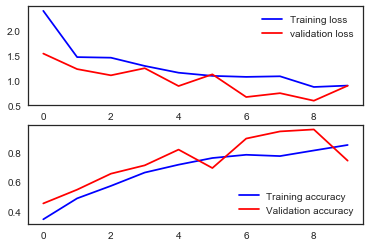

In [18]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

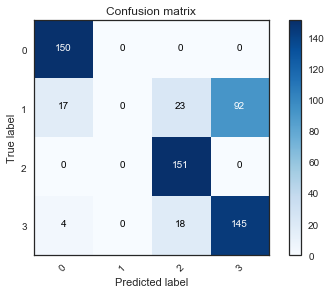

In [19]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 

In [20]:
#from keras.models import load_model
#model.save('lps_version_2.h5')  # creates a HDF5 file

In [29]:
from skimage.io import imread, imshow
import numpy as np
im = imread("Datasets/test_images/test.jpg")

In [30]:
from skimage.transform import resize
# resize to 150x150
im_resize = resize(im,(100,100), mode='constant')

from skimage.color import rgb2gray
# turn the image from color to gray
im_gray = rgb2gray(im_resize)/255.0

In [31]:
im_final = im_gray.reshape(-1,100,100,1)

# predict results
results = model.predict(im_final)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

print(results[0])

0


In [32]:
# the below output is a array of possibility of respective digit
ans = model.predict(im_final)

# choose the digit with greatest possibility as predicted dight
ans = ans[0].tolist().index(max(ans[0].tolist()))
print("the predicted room is",ans)

the predicted room is 0


In [25]:
# Display some error results 

# Errors are difference between predicted labels and true labels
#errors = (Y_pred_classes - Y_true != 0)

#Y_pred_classes_errors = Y_pred_classes[errors]
#Y_pred_errors = Y_pred[errors]
#Y_true_errors = Y_true[errors]
#X_val_errors = X_val[errors]

#def display_errors(errors_index,img_errors,pred_errors, obs_errors):
#    """ This function shows 6 images with their predicted and real labels"""
#    n = 0
#    nrows = 2
#    ncols = 4
#    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
#    for row in range(nrows):
#        for col in range(ncols):
#            error = errors_index[n]
#            ax[row,col].imshow((img_errors[error]).reshape((100, 100)))
#           ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
#            n += 1

# Probabilities of the wrong predicted numbers
#Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
#true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
#delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
#sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
#most_important_errors = sorted_dela_errors[-8:]

# Show the top 6 errors
#display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)
